In [1]:
%matplotlib inline

In [2]:
# Copyright (c) 2015-2022 MetPy Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause

# Sounding as Dataset Example

Use MetPy to make a Skew-T LogP plot from an xarray Dataset after computing LCL parcel
profile.

This example makes a skewT diagram with specified special lines while storing the sounding
data as an xarray dataset.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

Upper air data can be obtained using the siphon package, but for this example we will use
some of MetPy's sample data.

In [4]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

df = pd.read_fwf(get_test_data('20110522_OUN_12Z.txt', as_file_obj=False),
                 skiprows=7, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'),
               how='all').reset_index(drop=True)

We will pull the data out of the example dataset into individual variables and
assign units.

In [5]:
p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

ds = mpcalc.parcel_profile_with_lcl_as_dataset(p, T, Td)
print(list(ds.variables))

['ambient_temperature', 'ambient_dew_point', 'parcel_temperature', 'isobaric']


/Users/dcamron/projects/2026-ams-studentconference/.pixi/envs/default/lib/python3.14/site-packages/scipy/integrate/_ivp/base.py:24: UserWarning: Saturation mixing ratio is undefined for some requested pressure/temperature combinations. Total pressure must be greater than the water vapor saturation pressure for liquid water to be in equilibrium.
  return np.asarray(fun(t, y), dtype=dtype)


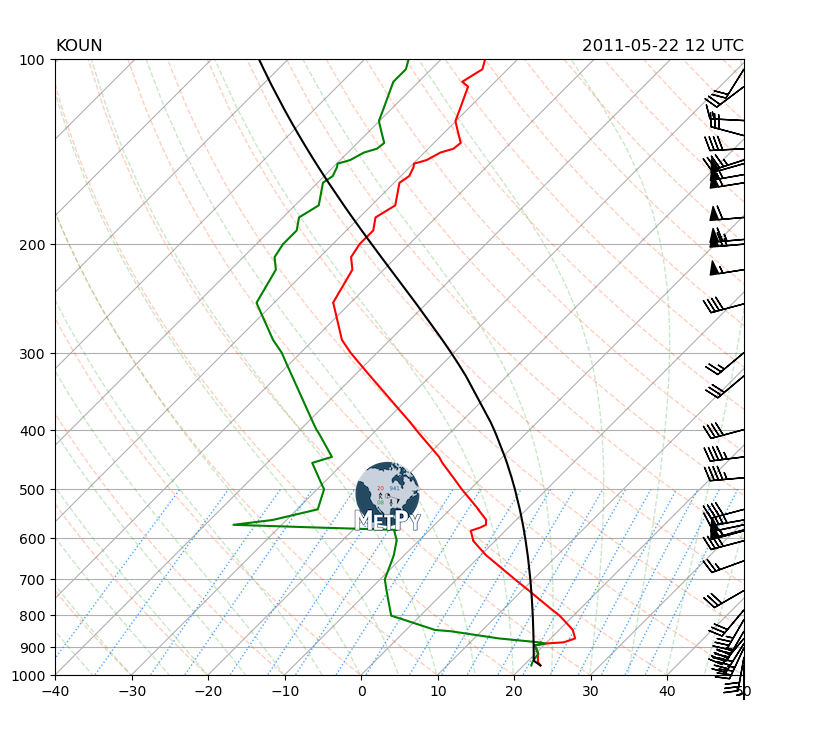

In [6]:
fig = plt.figure(figsize=(10, 8))
skew = SkewT(fig, rotation=45)

# Plot the data using the data from the xarray Dataset including the parcel temperature with
# the LCL level included
skew.plot(ds.isobaric, ds.ambient_temperature, 'r')
skew.plot(ds.isobaric, ds.ambient_dew_point, 'g')
skew.plot(ds.isobaric, ds.parcel_temperature.metpy.convert_units('degC'), 'black')

# Plot the wind barbs from the original data
skew.plot_barbs(p[::2], u[::2], v[::2])

# Add the relevant special lines
pressure = np.arange(1000, 499, -50) * units('hPa')
mixing_ratio = np.array([0.1, 0.2, 0.4, 0.6, 1, 1.5, 2, 3, 4,
                        6, 8, 10, 13, 16, 20, 25, 30, 36, 42]).reshape(-1, 1) * units('g/kg')

skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K, alpha=0.25,
                       colors='orangered', linewidths=1)
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K, alpha=0.25,
                         colors='tab:green', linewidths=1)
skew.plot_mixing_lines(pressure=pressure, mixing_ratio=mixing_ratio, linestyles='dotted',
                       colors='dodgerblue', linewidths=1)
skew.ax.set_ylim(1000, 100)

# Add the MetPy logo!
add_metpy_logo(fig, 350, 200)

# Add some titles
plt.title('KOUN', loc='left')
plt.title('2011-05-22 12 UTC', loc='right')

plt.show()